# Feedforward Neural Network + GraphBuilder

In this model a feedforward neural netowrk is trained on a subset of the total graphs. It is given a part tensor (consisting of a frequency encoding of the graph + one-hot encoding for the part) and outputs a tensor which contains the edge (neighbour) probabilities to all other parts/nodes. 
Based on these probabilities, we first build a fully connected weighted graph with the complementary probabilities (1 - probability). Then we calculate a minimumg spanning tree (therefore the complementary probabilities). Ultimately, we convert this minimum spanning tree (created with the NetworkX package) to our custom graph class.

# Setup

In [1]:
import os
import csv 


import random
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from graph_loader import load_graphs
import networkx as nx


from part import Part
from typing import Set

import torch.optim as optim

from evaluation import MyPredictionModel
from collections import Counter

import torch
import torch.nn as nn
from graph import Graph

In [2]:
# MPS for Metal acceleration for Mac
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
# device = torch.device("cpu")
SEED = 0
random.seed(SEED)
# setgrad = lambda g, *ms: [setattr(p,'requires_grad', g) for m in ms for p in m.parameters() ]  

# Hyperparameter:
input_dim = 4542        
hidden_dim = 1024       
output_dim = 2271      
learning_rate = 0.0005  
num_epochs = 50        
batch_size = 128          

## 0. Initial Analysis of Dataset

1621 0
1237 0
635 0
1621 0
802 0
118 0
531 0
1172 0
118 0
839 0
118 0
839 0
1124 0
1252 0
505 0
118 0
236 0
743 0
118 0
1886 0
0 0
118 0
505 0
738 0
1473 0
144 0
1316 0
118 0
663 0
1621 0
579 0
1696 0
118 0
2238 0
531 0
1166 0
505 0
413 0
504 0
193 0
1156 0
354 0
1839 0
172 0
418 0
259 0
181 0
1079 0
382 0
382 0
648 0
244 0
118 0
579 0
1109 0
245 0
848 0
259 0
505 0
848 0
118 0
431 0
118 0
663 0
623 0
325 0
236 0
721 0
531 0
118 0
1706 0
1166 0
287 0
1196 0
1402 0
663 0
413 0
1215 0
638 0
1402 0
382 0
1666 0
1166 0
118 0
118 0
181 0
1971 0
1191 0
663 0
1402 0
118 0
181 0
1218 0
118 0
742 0
781 0
118 0
181 0
259 0
118 0
1229 0
513 0
1316 0
492 0
930 0
382 0
552 0
278 0
421 0
1030 0
236 0
1738 0
663 0
325 0
118 0
618 0
494 0
181 0
118 0
1299 0
1839 0
181 0
0 0
118 0
673 0
1237 0
413 0
930 0
236 0
1666 0
839 0
172 0
414 0
1079 0
618 0
688 0
1216 0
1237 0
738 0
118 0
848 0
1394 0
181 0
264 0
1916 0
1836 0
509 0
506 0
1362 0
505 0
509 0
1196 0
1839 0
413 0
743 0
292 0
1222 0
509 0
839 0
118

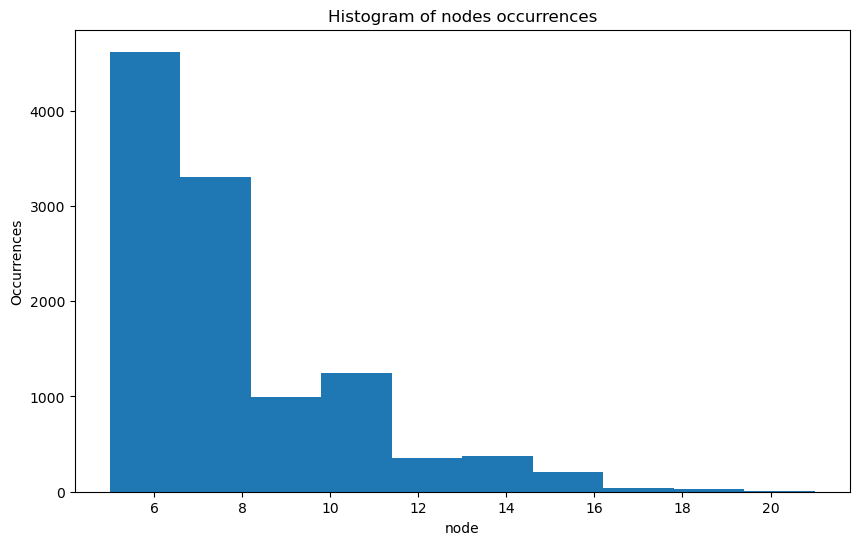

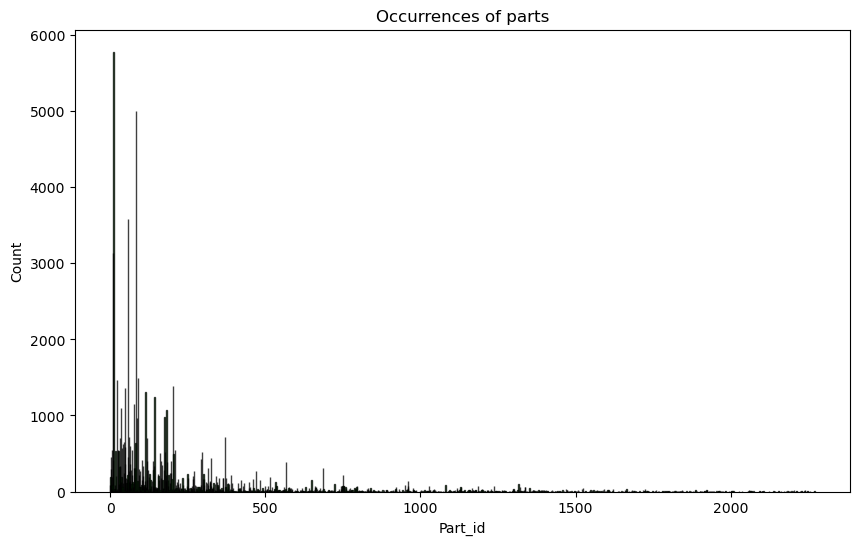

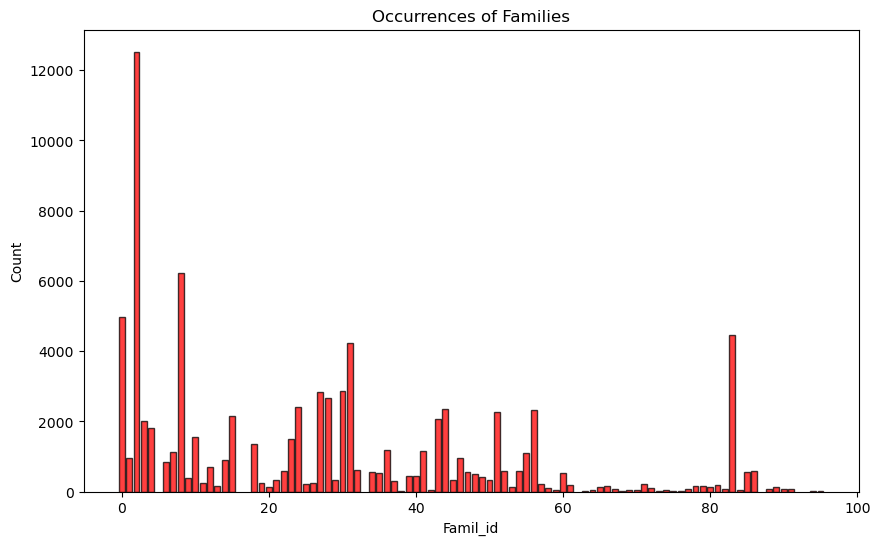

In [3]:
# descriptive analysis of the dataset
graphs = load_graphs("data/graphs.dat")
'''
graphs[0].draw()
print(graphs[0].get_parts())
print(graphs[0].get_nodes())
'''
number_of_graphs = len(graphs)
number_of_parts = 0
number_of_families = 0
number_of_connected_graphs = 0
number_of_cyclic_graphs = 0
number_of_nodes = []
part_id_counter = Counter()
family_id_counter = Counter()
node_id_counter = Counter()

part_set = set()



for graph in graphs:
    if graph.is_connected():
        number_of_connected_graphs += 1
    if graph.is_cyclic():
        number_of_cyclic_graphs += 1
    nodes = graph.get_nodes()
    parts = graph.get_parts()
    number_of_nodes.append(len(nodes))
    for node in nodes:
        node_id_counter[node.get_id] += 1
    for part in parts:
        p_id = int(part.get_part_id())
        part_set.add(p_id)
        part_id_counter[p_id] += 1
        family_id_counter[int(part.get_family_id())] += 1
        if int(part.get_family_id()) == 0:
            print(p_id, part.get_family_id())
        number_of_parts += 1
        number_of_families += 1

# cannot use get_parts method because it returns a set of nodes
print(f"Number of graphs: {number_of_graphs}")
print(f"Number of parts: {number_of_parts}")
print(f"Number of distinct parts: {len(part_set)}")
# Get the smallest part_id
smallest_part_id = min(part_set)
print(f"The smallest part_id is: {smallest_part_id}")


print(f"Number of families: {number_of_families}")
print(f"Number of connected graphs: {number_of_connected_graphs}")
print(f"Number of cyclic graphs: {number_of_cyclic_graphs}")



# Convert the Counter dictionary into two lists:
part_ids, counts = zip(*part_id_counter.items())

plt.figure(figsize=(10, 6))
plt.hist(number_of_nodes)
plt.xlabel("node")
plt.ylabel("Occurrences")
plt.title("Histogram of nodes occurrences")
plt.show()

parts, counts = zip(*part_id_counter.items())
# Visualization: Bar chart
plt.figure(figsize=(10, 6))
plt.bar(parts, counts, alpha=0.75, color='green', edgecolor='black')
plt.title("Occurrences of parts")
plt.xlabel("Part_id")
plt.ylabel("Count")
plt.show()

family, counts = zip(*family_id_counter.items())
# Visualization: Bar chart
plt.figure(figsize=(10, 6))
plt.bar(family, counts, alpha=0.75, color='red', edgecolor='black')
plt.title("Occurrences of Families")
plt.xlabel("Famil_id")
plt.ylabel("Count")
plt.show()

# 1. GraphDataSet

A custom dataset for training, validation, and testing, for the graphs.

In [4]:
from sklearn.model_selection import train_test_split


class GraphDataset(Dataset):
    def __init__(self, file_path: str, train=False, validation=False, test=False, seed=42):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found at {file_path}")

        self.graphs = load_graphs(file_path)

        if sum([train, validation, test]) != 1:
            raise ValueError("Exactly one of 'train', 'validation', or 'test' must be True.")


        # Create global mapping for unique parts
        self.family_part_dict = {}

        unique_parts = set()
        for graph in self.graphs:
            parts = graph.get_parts()
            for part in parts:
                unique_parts.add(int(part.get_part_id()))
                self.family_part_dict[int(part.get_part_id())] = int(part.get_family_id())

        # unique parts and mapping across all graphs (not just within a certain split)
        unique_parts = sorted(list(unique_parts))
        self.total_global_part_to_idx = {part: idx for idx, part in enumerate(unique_parts)} # mapping part_id to index
        self.idx_to_part_id = {idx: part for part, idx in self.total_global_part_to_idx.items()}  # Reverse mapping

        self.total_number_parts = max(unique_parts)+1

        # Split: 70% training, 15% validation, 15% test
        train_graphs, test_graphs = train_test_split(self.graphs, test_size=0.3, random_state=seed)
        validation_graphs, test_graphs = train_test_split(test_graphs, test_size=0.5, random_state=seed)

        # Create Train and Test Split:
        if train:
            self.graphs = train_graphs
        elif validation:
            self.graphs = validation_graphs
        elif test:
            self.graphs = test_graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        '''
        Returns the parts and the corresponding graph at the given index.
        '''
        return self.graphs[idx].get_parts(), self.graphs[idx]

    def encode_features(self, parts):
        """
            1. Sort all parts in a graph by part_id
            2. Does frequency encoding for parts 
            3. Does one-hot encoding for each part
            4. Combines encodings for every part in a stacked tensor
        """

        # sort parts by part_id and convert to list
        parts = sorted(parts, key=lambda part: int(part.get_part_id()))
        parts = list(parts)
        
        combined_tensors = []
        # frequency encoding
        part_frequency_tensor = self.frequency_encoding(parts)              # Done one time per graph for all parts
        for part in parts:
            # one hot encoding
            one_hot_encoded = self.one_hot_encoding(part)                   # Done for each part 
            combined_tensor = torch.cat((part_frequency_tensor, one_hot_encoded), dim=0)
            combined_tensors.append(combined_tensor)
        # transform list of tensors to tensor
        combined_tensors = torch.stack(combined_tensors)
        return combined_tensors

    def frequency_encoding(self, parts):
        """ 
        Frequency encoding of parts in a graph including the mapping to the global part index.
        """
        part_frequency_tensor = np.zeros(self.total_number_parts, dtype=np.int32)
        for part in parts:
            part_id = int(part.get_part_id())
            part_frequency_tensor[part_id] += 1
        # cast to tensor
        part_frequency_tensor = torch.tensor(part_frequency_tensor, dtype=torch.float32)
        return part_frequency_tensor

    def one_hot_encoding(self, part):
        """
        One-hot encoding of part including the mapping to the global part index.
        """
        one_hot_encoded = np.zeros(self.total_number_parts, dtype=np.int32)
        part_id = int(part.get_part_id())
        one_hot_encoded[part_id] = 1
        # cast to tensor
        one_hot_encoded = torch.tensor(one_hot_encoded, dtype=torch.float32)
        return one_hot_encoded

    
    def graph_to_neighbour_matrix(self, graph):
        """
        This will not create the adjacency matrix, but rather for each node a tensor with the neighbours. 
        These tensors are then stacked to create the neighbour matrix.

        Creates a one-hot encoded matrix for the neighbours of each node in the graph:
        top / x: Source, left / y: target

        Exactly as many columns as parts in graph (e.g. multiple columns for same partIDs) and in total rows per column for 2270 parts

            58, 58, 58, 58 1621 source
            1   2   3   4  5
        1
        2
        3               One-hot encoded
        ...
        target


        """
        neighbours = graph.get_edges()
        # sort nodes by part_id -> because our features were also sorted according to part_id
        nodes = sorted(graph.get_nodes(), key=lambda node: int(node.get_part().get_part_id()))

        neighbour_matrix = []

        for node in nodes:
            
            neighbour_tensor = torch.zeros(self.total_number_parts, dtype=torch.float32)
            # find the neighbours of each node
            for current_neighbour in neighbours[node]:
                neighbour_id = int(current_neighbour.get_part().get_part_id())
                neighbour_tensor[neighbour_id] = 1

            neighbour_matrix.append(neighbour_tensor)
        
        # transform list of tensors to tensor
        neighbour_matrix = torch.stack(neighbour_matrix)
        return neighbour_matrix


# 2. PartDataSet

A custom dataset for the parts within the graph datasets. The features contain all parts (frequency- & onehot-encoded) and the labels contain all "neighbour-probabilities" for the corresponding part.

In [5]:
class PartDataset(Dataset):
    def __init__(self, graph_dataset):
        """
        Initializes the PartDataset based on the existing GraphDataset.
        Creates a dataset that contains the combination of Frequency Encoding and One-Hot Encoding as features and the neighbors of each node as labels.

        :param graph_dataset: Instance of  GraphDataset.
        """
        self.features = []
        self.labels = []

        for parts, graph in graph_dataset:

            # Feature 1: Frequency encoded graph using part_ids
            part_ids_graph = graph.get_parts()
            part_ids_graph = [int(part.get_part_id()) for part in part_ids_graph]
            feature_graph = torch.zeros(graph_dataset.total_number_parts, dtype=torch.float)
            for part_id in part_ids_graph:
                feature_graph[part_id] += 1

            # Feature 2: One Hot encoding per Part + neighboring matrix created combined
            edges = graph.get_edges()
            for source_node, target_nodes in edges.items():
                source_id = int(source_node.get_part().get_part_id())

                # One-hot encode the source_id with pytorch tensors
                feature_source_id = torch.zeros(graph_dataset.total_number_parts, dtype=torch.float)
                feature_source_id[source_id] = 1

                target = torch.zeros(graph_dataset.total_number_parts, dtype=torch.float)
                for target_node in target_nodes:
                    target_id = int(target_node.get_part().get_part_id())
                    target[target_id] = 1

                self.labels.append(target)
                self.features.append(torch.cat([feature_graph, feature_source_id]))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        """
        Returns the features and the labels for the given index.
        """
        return self.features[idx], self.labels[idx]


# 3. Setup DataSets

In [6]:
training_set = GraphDataset("data/graphs.dat", train = True, seed=SEED)
validation_set = GraphDataset("data/graphs.dat", validation = True, seed=SEED)
testing_set = GraphDataset("data/graphs.dat", test = True, seed=SEED)

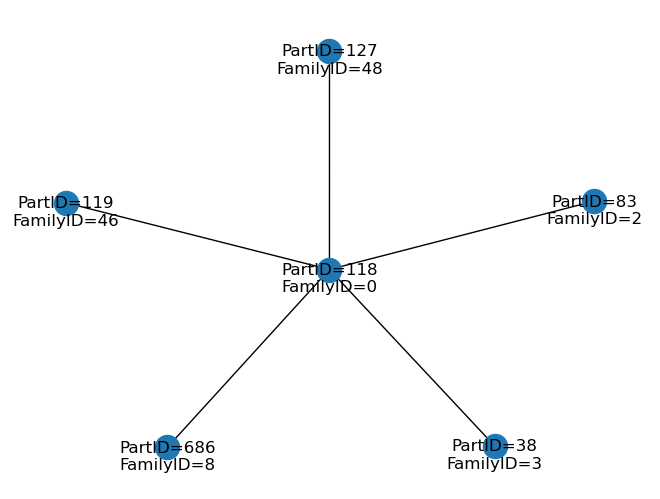

Features: ---------------------
4542
118     1.0
Labels / Edges: ---------------
38    1.0
83    1.0
119    1.0
127    1.0
686    1.0


In [7]:
# Creates a PartDataset from the GraphDataset
train_part_dataset = PartDataset(training_set)      # --> Length 59275 all parts in all graphs (all graphs - PArtID combis)
val_part_dataset = PartDataset(validation_set)

training_set.graphs[0].draw()
example_column = 0      # Max 59275

# Exploration of the dataset
print("Features: ---------------------")
print(len(train_part_dataset.features[0]))
for i, part in enumerate(train_part_dataset.features[example_column]):
    if i > output_dim and train_part_dataset.features[example_column][i].item() > 0:
        print(i - output_dim, "   ", train_part_dataset.features[example_column][i].item())

print("Labels / Edges: ---------------")
for i, edge in enumerate(train_part_dataset.labels[example_column]):
    if train_part_dataset.labels[example_column][i].item() > 0:
        print(i, "  ", train_part_dataset.labels[example_column][i].item())


In [8]:
# Exploration

# Print all Edges in Graph 0:
for j in range(0,6):
    for i, element in enumerate(train_part_dataset[j][0]):
        if i >= (output_dim-1) and element >= 1:
            print(f"source -> part_id {i - output_dim}")

    # neighbours
    for i, element in enumerate(train_part_dataset[j][1]):
        if element > 0:
            print(f"target -> part_id {i}")
    
    print(50*"-")

source -> part_id 118
target -> part_id 38
target -> part_id 83
target -> part_id 119
target -> part_id 127
target -> part_id 686
--------------------------------------------------
source -> part_id 127
target -> part_id 118
--------------------------------------------------
source -> part_id 119
target -> part_id 118
--------------------------------------------------
source -> part_id 38
target -> part_id 118
--------------------------------------------------
source -> part_id 83
target -> part_id 118
--------------------------------------------------
source -> part_id 686
target -> part_id 118
--------------------------------------------------


# Neighbour Prediction

Predicts the probabilities for every neighbour of a part.

The neighbour prediction model aims to predict the probabilities of each part being connected to other parts in a graph. The process involves several key steps:

1. **Data Preparation** (already done):
    - The dataset is split into training, validation, and testing sets.
    - Each part in the graph is encoded using frequency encoding and one-hot encoding.

2. **Model Architecture**:
    - A Feedforward Neural Network (FFNN) is used for prediction.
    - The FFNN consists of an input layer, two hidden layers, and an output layer with sigmoid activation.

3. **Training**:
    - The model is trained using the Binary Cross-Entropy Loss function and the Adam optimizer.
    - Training involves multiple epochs, and the model's performance is evaluated on both training and validation sets.

4. **Prediction**:
    - For each part, the model predicts the probabilities of it being connected to other parts.
    - These probabilities are used to build a fully connected weighted graph.

5. **Graph Construction**:
    - A minimum spanning tree is constructed from the fully connected graph using the complementary probabilities (1 - probability).
    - The minimum spanning tree is then converted to a custom graph class.

6. **Evaluation**:
    - The model's performance is evaluated on the testing set.
    - The accuracy of the neighbour prediction is calculated and saved for further analysis.

This approach allows for the prediction of neighbour relationships in a graph, which can be used for various applications such as graph reconstruction and analysis.

## Feedforward Neural Network



A simple feedforward neural network consisting of an input layer, 2 hidden layers and one output layer.

In [9]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self._init_weights()

    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
        

    def train_ffnn(self, train_dataset, val_dataset, num_epochs, batch_size, learning_rate, device):

        # Move model to device
        self.to(device)

        # Initialize criterion and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        # Prepare DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        # Document Losses and Accuracies
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):

            # Training Phase:
            self.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for batch_inputs, batch_labels in train_loader:
                batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

                optimizer.zero_grad()
                outputs = self(batch_inputs)  # Forward pass
                loss = criterion(outputs, batch_labels)  # Compute loss

                # Backwards Pass and Update weights:
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate training accuracy
                predictions = (outputs >= 0.5).float()  # Round probabilities to 0 or 1
                correct_train += (predictions == batch_labels).sum().item()  # Count correct predictions
                total_train += batch_labels.numel()  # Total number of labels

            avg_train_loss = running_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            train_accuracy = correct_train / total_train  # Accuracy as ratio
            train_accuracies.append(train_accuracy)

            # Validation Phase:
            self.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = self(val_inputs)  # Forward pass
                    val_loss = criterion(val_outputs, val_targets)  # Compute loss
                    running_val_loss += val_loss.item()

                    # Calculate validation accuracy
                    val_predictions = (val_outputs >= 0.5).float()  # Round probabilities to 0 or 1
                    correct_val += (val_predictions == val_targets).sum().item()  # Count correct predictions
                    total_val += val_targets.numel()  # Total number of labels

            avg_val_loss = running_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            val_accuracy = correct_val / total_val  # Accuracy as ratio
            val_accuracies.append(val_accuracy)

            # Print epoch summary
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Train Acc: {train_accuracy:.4f}, "
                f"Val Loss: {avg_val_loss:.6f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies


    def test_ffnn(self, test_dataset, batch_size, device):
        self.eval()
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        criterion = nn.BCELoss()

        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = self(test_inputs)
        
                test_loss = criterion(test_outputs, test_targets)
                running_test_loss += test_loss.item()

                # Calculate test accuracy
                test_predictions = (test_outputs >= 0.5).float()
                correct_test += (test_predictions == test_targets).sum().item()
                total_test += test_targets.numel()
        
        avg_test_loss = running_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test

        print(f"Test Loss: {avg_test_loss:.6f}, Test Acc: {test_accuracy:.4f}")
        return avg_test_loss, test_accuracy


# Graph Builder

The model predicts the probabilities of each part being connected to other parts, which are then used to construct a fully connected weighted graph. From this graph, a minimum spanning tree is generated using the complementary probabilities (1 - probability). Finally, the minimum spanning tree is converted into a custom graph class.

In [10]:
class GraphBuilder(MyPredictionModel):
    def __init__(self):
        super().__init__()
        self.model = None

    def load_model(self, input_dim, hidden_dim, output_dim, file_path: str) -> MyPredictionModel:

        # Ensure the model is initialized with the same architecture
        model = FFNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

        # Load the saved state_dict with weights_only=True for security
        state_dict = torch.load(file_path, weights_only=True)
        model.load_state_dict(state_dict)

        # Set the model to evaluation mode (important for inference)
        model.eval()

        # Store it in the class instance
        self.model = model
        return model

    def predict_graph(self, parts: Set[Part]) -> Graph:

        part_ids = []
        for part in parts:
            part_ids.append(part.get_part_id())

        # Generate Probability Matrix:
        output_matrix = self.__query_probabilities(part_ids)

        # Convert the output_matrix to a dictionary
        probabilities_dict = {}             # probabilities_dict[source][target]
        for i, part_id in enumerate(part_ids):
            column_probabilities = output_matrix[:, i]
            probabilities_dict[part_id] = {row_idx: column_probabilities[row_idx].item() for row_idx in range(output_matrix.size(0))}

        # Build up the Graph:
        predicted_graph = self.__build_predicted_graph(parts, probabilities_dict)

        return predicted_graph

    def __query_probabilities(self, part_ids: list):

        # Generate Frequency Encoding:
        frequency_vector = torch.zeros(output_dim, dtype=torch.float32)
        for part_id in part_ids:
            frequency_vector[int(part_id)] += 1

        # Initialize a tensor to hold the outputs (2271 rows, 6 columns)
        output_matrix = torch.zeros(output_dim, len(part_ids), dtype=torch.float32)  # Shape: (2271, 6)

        # Generate One Hot Encoding and combined Vector:
        for i, part_id in enumerate(part_ids):
            one_hot_vector = torch.zeros(output_dim, dtype=torch.float32) # Initialize a zero vector for one-hot encoding
            one_hot_vector[int(part_id)] = 1.0                      # Set the part_id index to 1
            combined_vector = torch.cat([frequency_vector, one_hot_vector], dim=0)

            # Query Model
            model_output_per_part = ffnn(combined_vector.unsqueeze(0).to(device))

            # Squeeze the output and assign it to the corresponding column in the matrix
            output_matrix[:, i] = model_output_per_part.squeeze(0).cpu()

        return output_matrix

    # Function to create the predicted graph
    def __build_predicted_graph(self, parts: list, edge_probabilities: dict) -> Graph:

        # Initialize Empty Graph with parts
        G = self.__create_empty_graph(parts)

        for source_node in G.nodes:
            for target_node in G.nodes:
                if source_node == target_node:
                    continue
                source_id = source_node.get_part_id()
                target_id = int(target_node.get_part_id())
                edge_prob = edge_probabilities[source_id].get(target_id, 0)

                # Add edges
                weight = 1 - edge_prob
                G.add_edge(source_node, target_node, weight=weight)

        # Minimum spanning Tree
        mst = nx.minimum_spanning_tree(G)

        # Build graph
        predicted_graph = Graph()
        for edge in mst.edges():
            predicted_graph.add_undirected_edge(edge[0], edge[1])

        return predicted_graph

    def __create_empty_graph(self, parts: Set[Part]) -> Graph:
        graph = nx.Graph()
        graph.add_nodes_from(parts)
        return graph

    def draw_tree(self, tree, title="Minimum Spanning Tree"):
        # Generate layout positions for the tree (spring layout works well for small graphs)
        pos = nx.spring_layout(tree)  # You can use other layouts like nx.kamada_kawai_layout(tree)

        # Draw the graph
        plt.figure(figsize=(10, 8))
        nx.draw(tree, pos, with_labels=True, node_size=500, font_size=10, node_color="skyblue", edge_color="gray")

        # Draw edge weights
        edge_labels = nx.get_edge_attributes(tree, 'weight')
        nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size=9)

        # Add a title
        plt.title(title)
        plt.show()

## Hyperparameter Tuning

Initialize the validation list which is passed to the graph builder.

In [11]:
validation_list = []
for parts, graph in validation_set:
    tuple = (parts, graph)
    validation_list.append(tuple)

For the hyperparameter tuning we employ grid search with 27 combinations in total. 
We select the hidden dimension in the neural network and the batch size and the learning rate for the training as hyperparameter.
All intermediate results can be found as csv files in the `hyperparameter` folder.
It's important to note that in the end we want to maximize the edge accuracy with our hyperparameter search.

In [12]:
from evaluation import evaluate

hyper_param_tuning_done = True
if not hyper_param_tuning_done:
    ## Hyperparameter Tuning for the following values
    hidden_dims = [128, 1024, 4542]
    batch_sizes = [512, 1024, 2048]
    learning_rates = [0.01, 0.001, 0.0005]

    # Initialize the results list
    results = []

    # Iterate over all hyperparameter combinations
    for hidden_dim in hidden_dims:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                # Train the model
                ffnn = FFNN(input_dim, hidden_dim, output_dim).to(device)
                train_losses, val_losses, train_accuracies, val_accuracies = ffnn.train_ffnn(
                    train_dataset=train_part_dataset,
                    val_dataset=val_part_dataset,
                    num_epochs=num_epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    device=device
                )

                # store the results as csvs
                # Prepare results for saving
                results = []
                for epoch in range(len(train_losses)):
                    results.append({
                        "epoch": epoch + 1,
                        "train_loss": train_losses[epoch],
                        "train_accuracy": train_accuracies[epoch],
                        "val_loss": val_losses[epoch],
                        "val_accuracy": val_accuracies[epoch]
                    })
                

                # Create the folder if it doesn't exist
                output_folder = "hyperparameter"
                os.makedirs(output_folder, exist_ok=True)

                # Save results to CSV
                output_file = os.path.join(output_folder, f"{hidden_dim}-{batch_size}-{learning_rate}-training_results.csv")
                with open(output_file, "w", newline="") as csvfile:
                    fieldnames = ["epoch", "train_loss", "train_accuracy", "val_loss", "val_accuracy"]
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

                    writer.writeheader()
                    writer.writerows(results)


                # Save the trained model
                file_path = f"ffnn_model_{hidden_dim}_{batch_size}_{learning_rate}.pth"

                torch.save(ffnn.state_dict(), file_path)
                print(f"Model saved to {file_path}")

                # Initialize and load the model
                builder = GraphBuilder()
                builder.load_model(input_dim, hidden_dim, output_dim, file_path)

                # Evaluate the model
                edge_accuracy = evaluate(builder, validation_list)

                # Save accuracy to CSV
                output_file = os.path.join(output_folder, f"{hidden_dim}-{batch_size}-{learning_rate}-edge_accuracy.csv")
                with open(output_file, "w", newline="") as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(["edge_accuracy"])  # Write the header
                    writer.writerow([edge_accuracy])
                
                print(f"Evaluation result saved to {output_file}")
                

                # Store the results
                results.append({
                    "hidden_dim": hidden_dim,
                    "batch_size": batch_size,
                    "learning_rate": learning_rate,
                    "accuracy": edge_accuracy
                })

Go through all the created csv files and select the hyperparameter combination with the best edge accuracy.

In [13]:
import os
import pandas as pd

# Directory containing the CSV files
directory = "hyperparameter"

# Initialize variables to track the best and worst models
best_model = {"file": None, "accuracy": float("-inf")}
worst_model = {"file": None, "accuracy": float("inf")}

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith("-edge_accuracy.csv"):
        filepath = os.path.join(directory, filename)
        try:
            # Read the CSV file (expecting one value in the edge_accuracy column)
            df = pd.read_csv(filepath)

            # Ensure the file contains the 'edge_accuracy' column
            if "edge_accuracy" in df.columns:
                accuracy = df["edge_accuracy"].iloc[0]  # Get the single accuracy value

                # Update best model if the current accuracy is higher
                if accuracy > best_model["accuracy"]:
                    best_model = {"file": filename, "accuracy": accuracy}

                # Update worst model if the current accuracy is lower
                if accuracy < worst_model["accuracy"]:
                    worst_model = {"file": filename, "accuracy": accuracy}
            else:
                print(f"File {filename} does not contain the expected 'edge_accuracy' column.")
        except Exception as e:
            print(f"Error reading file {filename}: {e}")

best_hidden_dim = best_model["file"].split("-")[0]
best_batch_size = best_model["file"].split("-")[1]
best_learning_rate = best_model["file"].split("-")[2]
worst_hidden_dim = worst_model["file"].split("-")[0]
worst_batch_size = worst_model["file"].split("-")[1]
worst_learning_rate = worst_model["file"].split("-")[2]
# Output the results
print("Best Overall Model:")
print(f"File: {best_model['file']}")
print(f"Edge Accuracy: {best_model['accuracy']}")
print(f"hidden_dim: {best_hidden_dim}")
print(f"batch_size: {best_batch_size}")
print(f"learning_rate: {best_learning_rate}")
print("\nWorst Overall Model:")
print(f"File: {worst_model['file']}")
print(f"Edge Accuracy: {worst_model['accuracy']}")
print(f"hidden_dim: {worst_hidden_dim}")
print(f"batch_size: {worst_batch_size}")
print(f"learning_rate: {worst_learning_rate}")


Best Overall Model:
File: 1024-512-0.001-edge_accuracy.csv
Edge Accuracy: 96.82781649245064
hidden_dim: 1024
batch_size: 512
learning_rate: 0.001

Worst Overall Model:
File: 4542-512-0.01-edge_accuracy.csv
Edge Accuracy: 70.01669570267131
hidden_dim: 4542
batch_size: 512
learning_rate: 0.01


## Testing with optimal hyperparameter

After having the optimal hyperparameter (which maximize the edge accuracy of the graph builder), we train our neural network with the hyperparameter on the training and validation part sets and then test it on the testing part set. Finally, we try the graph builder with the testing_list.

Epoch [1/50], Train Loss: 0.043362, Train Acc: 0.9911, Val Loss: 0.005772, Val Acc: 0.9993
Epoch [2/50], Train Loss: 0.004285, Train Acc: 0.9993, Val Loss: 0.003514, Val Acc: 0.9993
Epoch [3/50], Train Loss: 0.002858, Train Acc: 0.9993, Val Loss: 0.002530, Val Acc: 0.9994
Epoch [4/50], Train Loss: 0.002061, Train Acc: 0.9994, Val Loss: 0.001810, Val Acc: 0.9995
Epoch [5/50], Train Loss: 0.001417, Train Acc: 0.9996, Val Loss: 0.001280, Val Acc: 0.9996
Epoch [6/50], Train Loss: 0.000949, Train Acc: 0.9997, Val Loss: 0.000874, Val Acc: 0.9997
Epoch [7/50], Train Loss: 0.000650, Train Acc: 0.9998, Val Loss: 0.000629, Val Acc: 0.9998
Epoch [8/50], Train Loss: 0.000461, Train Acc: 0.9999, Val Loss: 0.000494, Val Acc: 0.9999
Epoch [9/50], Train Loss: 0.000349, Train Acc: 0.9999, Val Loss: 0.000386, Val Acc: 0.9999
Epoch [10/50], Train Loss: 0.000275, Train Acc: 0.9999, Val Loss: 0.000343, Val Acc: 0.9999
Epoch [11/50], Train Loss: 0.000228, Train Acc: 0.9999, Val Loss: 0.000297, Val Acc: 0.99

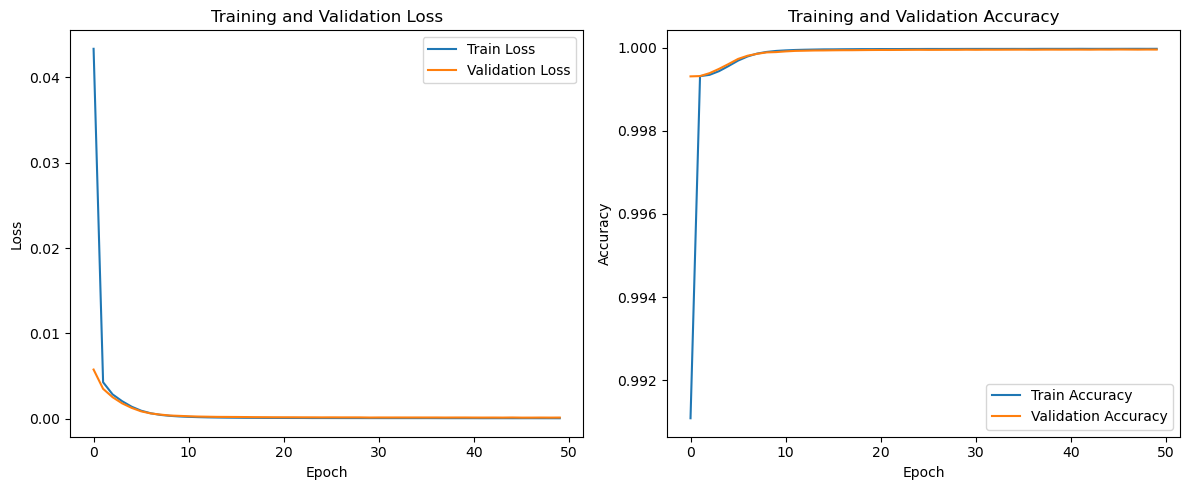

Test Loss: 0.000142, Test Acc: 1.0000
Test Accuracy:  0.9999566973947032
Test Loss:  0.00014155614917399362
Accuracy of NeighbourGraphPredictionModel:  97.03277599279129


In [14]:
testing_list = []
for parts, graph in testing_set:
    tuple = (parts, graph)
    testing_list.append(tuple)

# train the model with the best hyperparameters
ffnn = FFNN(input_dim, int(best_hidden_dim), output_dim).to(device)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = ffnn.train_ffnn(
    train_dataset=train_part_dataset,
    val_dataset=val_part_dataset,
    num_epochs=num_epochs,
    batch_size=int(best_batch_size),
    learning_rate=float(best_learning_rate),
    device=device
)

# Save the trained model
file_path = f"ffnn_model_best.pth"
torch.save(ffnn.state_dict(), file_path)
print(f"Model saved to {file_path}")

# Visualize the training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.tight_layout()

plt.show()


# Test the model
test_part_dataset = PartDataset(testing_set)   

avg_test_loss, test_accuracy = ffnn.test_ffnn(test_part_dataset, batch_size=int(best_batch_size), device=device)

print("Test Accuracy: ", test_accuracy)
print("Test Loss: ", avg_test_loss)


# Initialize and load the model
builder = GraphBuilder()

# Load the best model
builder.load_model(input_dim, int(best_hidden_dim), output_dim, file_path)

# Evaluate the model
edge_accuracy = evaluate(builder, testing_list)
print("Accuracy of NeighbourGraphPredictionModel: ", edge_accuracy)

# Visualize HPO

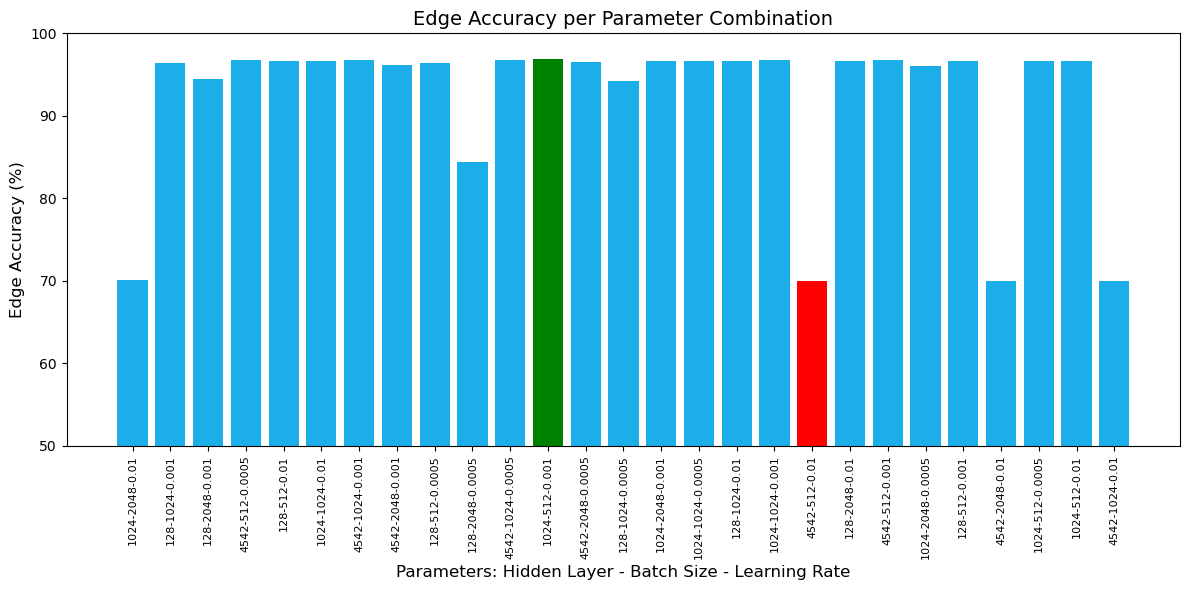

In [15]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Directory containing the CSV files
directory = "hyperparameter"
results = []
filename_data = {}

# Initialize variables to track the best and worst models
best_model = {"file": None, "accuracy": float("-inf")}
worst_model = {"file": None, "accuracy": float("inf")}

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith("-edge_accuracy.csv"):

        # Extract Information
        match = re.match(r"(\d+)-(\d+)-([\d.]+)-edge_accuracy\.csv", filename)
        if match:
            # Extract the values from the filename
            param_hidden_layer = int(match.group(1))     # First number (e.g., 4542 or 128)
            param_batches = int(match.group(2))     # Second number (e.g., 2048 or 512)
            param_lr = float(match.group(3))   # Third number (e.g., 0.0005 or 0.001)

            # Store in the dictionary
            filename_data[filename] = {
                "Param1": param_hidden_layer,
                "Param2": param_batches,
                "Param3": param_lr
            }

        # Extract Performances
        filepath = os.path.join(directory, filename)
        try:
            # Read the CSV file (expecting one value in the edge_accuracy column)
            df = pd.read_csv(filepath)

            # Ensure the file contains the 'edge_accuracy' column
            if "edge_accuracy" in df.columns:
                accuracy = df["edge_accuracy"].iloc[0]  # Get the single accuracy value
                current_index = len(results)  # Use the current length of results as the index
                results.append({
                    "Params": f"{param_hidden_layer}-{param_batches}-{param_lr}",
                    "Edge_Accuracy": accuracy
                })

                # Update best model if the current accuracy is higher
                if accuracy > best_model["accuracy"]:
                    best_model = {"file": current_index, "accuracy": accuracy}

                # Update worst model if the current accuracy is lower
                if accuracy < worst_model["accuracy"]:
                    worst_model = {"file": current_index, "accuracy": accuracy}

            else:
                print(f"File {filename} does not contain the expected 'edge_accuracy' column.")

        except Exception as e:
            print(f"Error reading file {filename}: {e}")

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Colors
colors = ['#1caee8' for _ in range(len(results_df))]
colors[best_model['file']] = 'green'
colors[worst_model['file']] = 'red'

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(results_df["Params"], results_df["Edge_Accuracy"], color=colors)

# Customize the chart
plt.xlabel("Parameters: Hidden Layer - Batch Size - Learning Rate", fontsize=12)
plt.ylabel("Edge Accuracy (%)", fontsize=12)
plt.title("Edge Accuracy per Parameter Combination", fontsize=14)
plt.xticks(rotation=90, fontsize=8)  # Set labels to vertical
plt.ylim(50, 100)
plt.tight_layout()

# Show the chart
plt.show()